In [1]:
from pathlib import Path
import numpy as np
import u_net, data_setup, utils, engine, plot


In [2]:
in_dir = Path.cwd()
target_dir = in_dir.parent / 'models'
target_dir.is_dir()

True

## 1. Load the metric data

In [3]:
train_loss = np.load(target_dir / 'train_loss.npy' )
train_metric = np.load(target_dir / 'train_metric.npy')
test_loss = np.load(target_dir / 'test_loss.npy')
test_metric = np.load(target_dir / 'test_metric.npy')

In [4]:
# Debug
(target_dir / 'train_loss.npy').is_file(),(target_dir / 'train_metric.npy').is_file(), (target_dir / 'test_loss.npy').is_file(), (target_dir / 'test_metric.npy').is_file()


(True, True, True, True)

## 2. Plot the metric data

<Figure size 640x480 with 0 Axes>

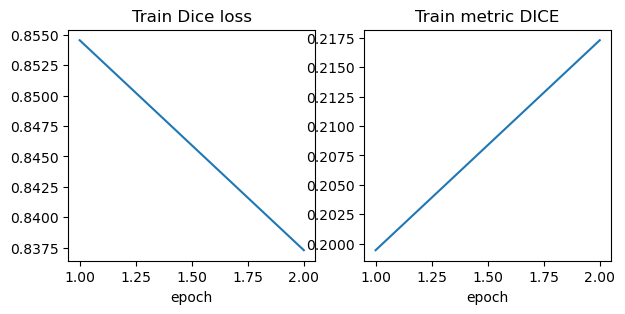

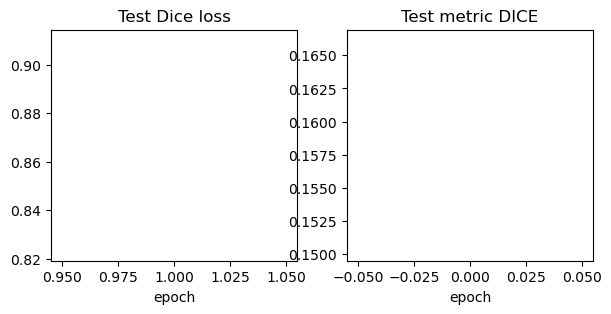

In [5]:
plot.plot_metric(train_loss = train_loss,
                  train_metric = train_metric,
                  test_loss = test_loss,
                  test_metric = test_metric)

### For visualization with TensorBoard, use "Tensorboard --logdir ..\runs" in the command line and open TensorBoard in your browser with "localhost:6007".

## 3. Plotting the prediction

### 3.1 Get the test data loader

3.1.1 Use this function to create dataloader with labels

In [3]:
_, test_dataloader = data_setup.prepare_train_eval_data(in_dir = in_dir.parent / 'data',
                                                        a_max = 300)

c:\Users\graumnitz\AppData\Local\anaconda3\envs\heart\Lib\site-packages\monai\utils\deprecate_utils.py:321: FutureWarning: monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.
  warn_deprecated(argname, msg, warning_category)


3.1.2 Use this function to create a dataloader without labels

In [19]:
test_dataloader = data_setup.prepare_test_data(in_dir = in_dir.parent / 'data',
                                        a_max = 300)

[WindowsPath('d:/Meine Ablage/@ Adrian/__heartsegmentation/data/test_volumes/10_tho__cta__075__b30f__bestdiast_75_.nii.gz'), WindowsPath('d:/Meine Ablage/@ Adrian/__heartsegmentation/data/test_volumes/11_cta_spirale__30__b30f__bestdiast_75_.nii.gz'), WindowsPath('d:/Meine Ablage/@ Adrian/__heartsegmentation/data/test_volumes/12_fl_thx_venos__20__b31f.nii.gz'), WindowsPath('d:/Meine Ablage/@ Adrian/__heartsegmentation/data/test_volumes/13_fl_thx_venos__075__b31f.nii.gz'), WindowsPath('d:/Meine Ablage/@ Adrian/__heartsegmentation/data/test_volumes/14_fl_thx_venos_lcad_20__b60f.nii.gz'), WindowsPath('d:/Meine Ablage/@ Adrian/__heartsegmentation/data/test_volumes/15_fl_thx_venos_lcad_075__b60f.nii.gz'), WindowsPath('d:/Meine Ablage/@ Adrian/__heartsegmentation/data/test_volumes/16_cta_spirale__30__b30f__bestdiast_71_.nii.gz'), WindowsPath('d:/Meine Ablage/@ Adrian/__heartsegmentation/data/test_volumes/17_bestdia__cta_spirale__075__b30f__bestdiast_71_.nii.gz'), WindowsPath('d:/Meine Ablage/

### 3.2 Loading a pretrained model

* You need to insert the name of your trained model into the load_weights function, assigning it to the target_dir parameter.

In [4]:
num_classes = utils.number_of_classes(in_dir = in_dir.parent / 'data' / 'train_segmentations')
model, device = u_net.unet(num_classes = num_classes)
model = utils.load_weights(model = model,
                           target_dir = target_dir / 'ModelV12_DiceLoss.pth').to(device)
model.eval()

[INFO] Number of classes: 8
Layer (type (var_name))                                                               Input Shape               Output Shape              Param #                   Trainable
UNet (UNet)                                                                           [1, 1, 128, 128, 64]      [1, 8, 128, 128, 64]      --                        True
├─Sequential (model)                                                                  [1, 1, 128, 128, 64]      [1, 8, 128, 128, 64]      --                        True
│    └─ResidualUnit (0)                                                               [1, 1, 128, 128, 64]      [1, 16, 64, 64, 32]       --                        True
│    │    └─Conv3d (residual)                                                         [1, 1, 128, 128, 64]      [1, 16, 64, 64, 32]       448                       True
│    │    └─Sequential (conv)                                                         [1, 1, 128, 128, 64]      [1, 16, 64

UNet(
  (model): Sequential(
    (0): ResidualUnit(
      (conv): Sequential(
        (unit0): Convolution(
          (conv): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
          (adn): ADN(
            (N): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
        (unit1): Convolution(
          (conv): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (adn): ADN(
            (N): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
      )
      (residual): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    )
    (1): SkipConnection(
      (submodule): Sequential(
        (0): ResidualUnit(
          (conv): Sequential(


### 3.3 Get one dataset from the test dataloader

In [11]:
test_patient = next(iter(test_dataloader))
    

### 3.4 Make a prediction with the dataset on the model

In [23]:
prediction, output = engine.perform_inference(model = model,
                                              test_patient = test_patient)

[INFO]
Image shape: torch.Size([1, 1, 128, 128, 64])
Label shape: torch.Size([1, 1, 128, 128, 64])
Binary segmentation shape: torch.Size([1, 8, 128, 128, 64])
Multi segmentation shape: torch.Size([1, 1, 128, 128, 64])


### 3.5 Plot the prediction with matplotlib

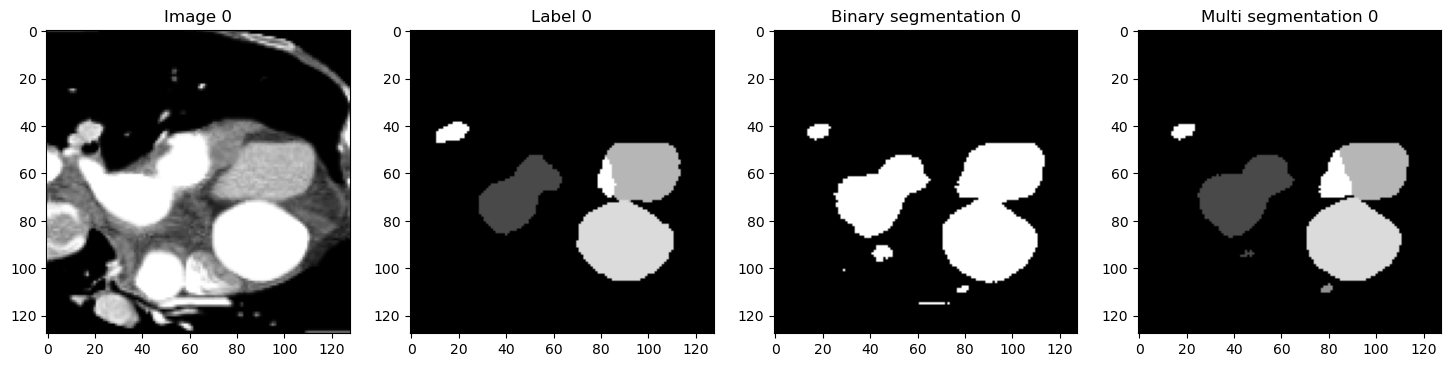

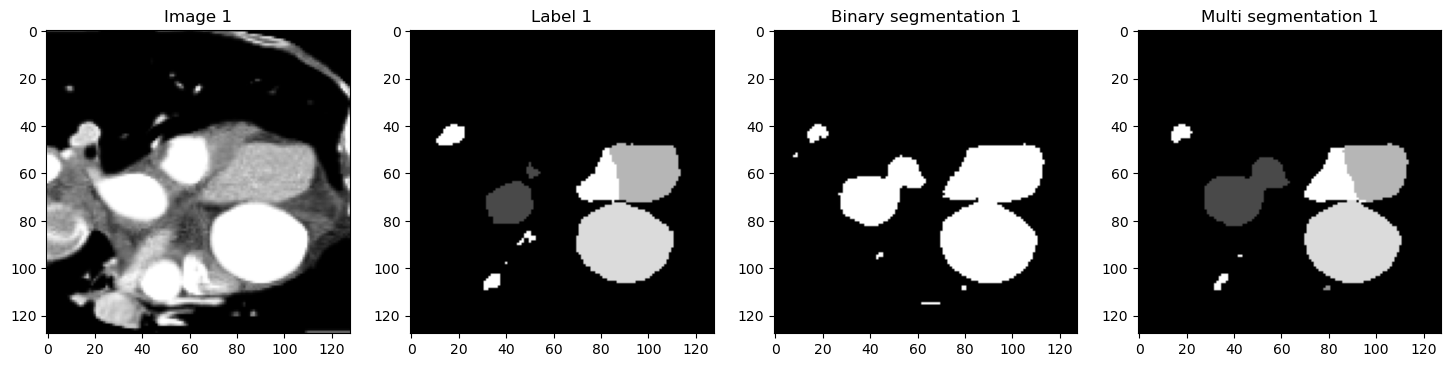

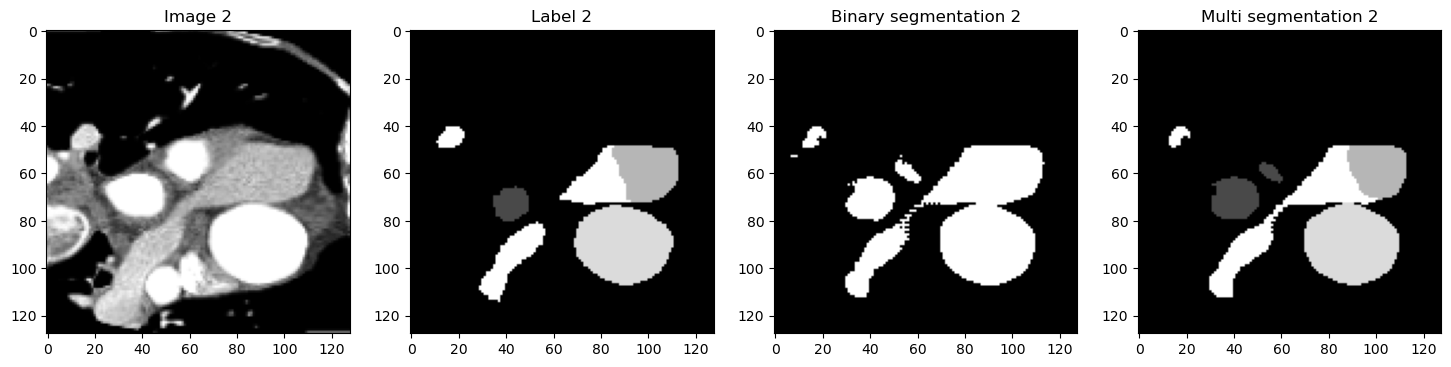

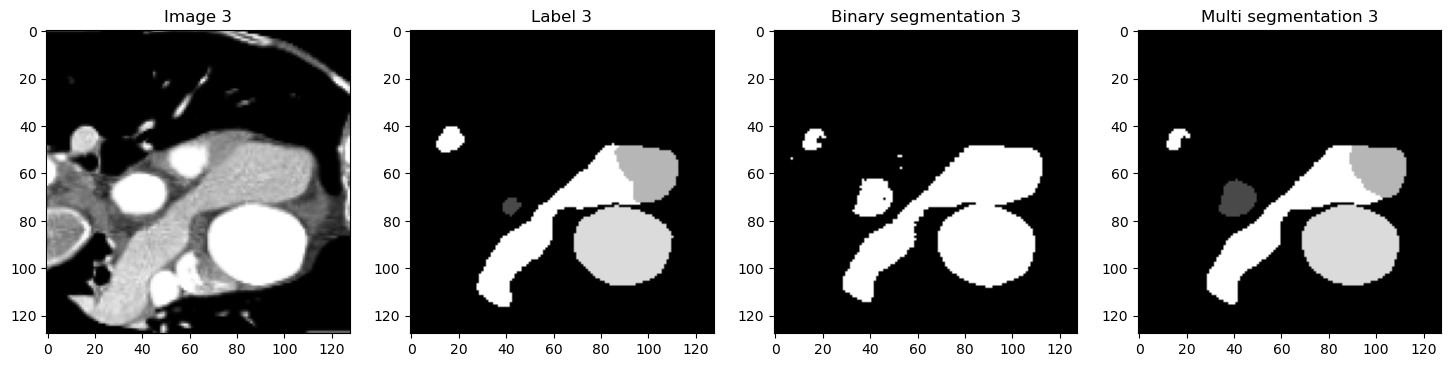

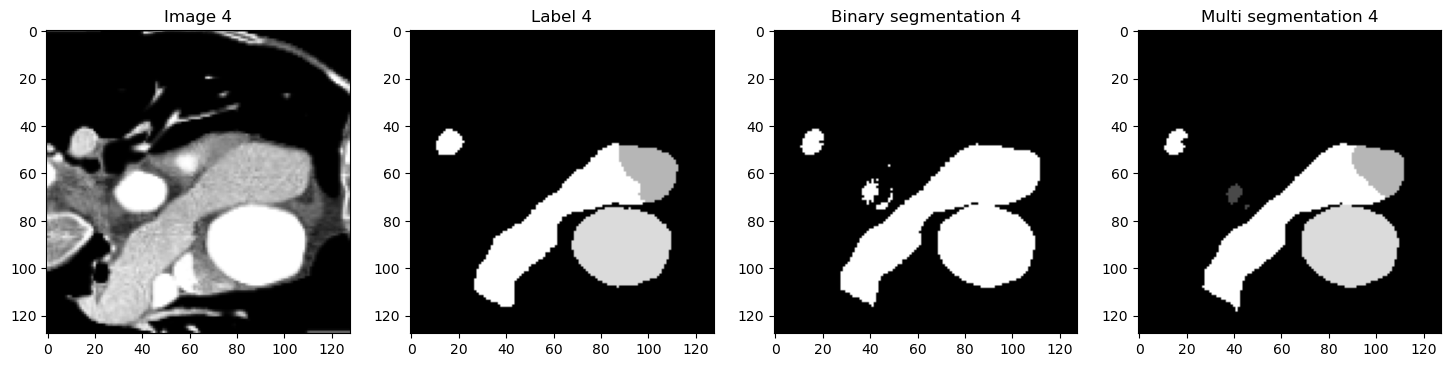

In [24]:
plot.plot_image_label_prediction(test_patient = test_patient,
                                  prediction = prediction,
                                  test_outputs = output)

## 4. Create a list with your predictions, a list with your labels and a list with the class_names

* If you make only predictions without labels, ignore the label list because it is empty

### 4.1 Create a list with predictions and a list with labels

In [5]:
prediction_list, label_list = engine.create_prediction_list(model = model,
                                                            test_dataloader = test_dataloader)

### 4.2 Create a list with predictions without labels

In [14]:
prediction_list, _ = engine.create_prediction_list(model = model,
                                                test_dataloader = test_dataloader)

### 4.3 Create a list with your class_names
* necessary for the Confusion Matrix
* optional for plotting a mesh

In [6]:
class_names = ['Background', 'Myocardium', 'Left Atrium', 'Left Ventricle', 'Right Atrium', 'Right Ventricle', 'Ascending Aorta', 'Pulmonary Arteria']

## 5. Create a confusion matrix

* To generate a confusion matrix, you need both predictions and their corresponding labels

[metatensor([[[[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]],
 
          [[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]],
 
          [[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]],
 
          ...,
 
          [[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]],
 
          [[0, 

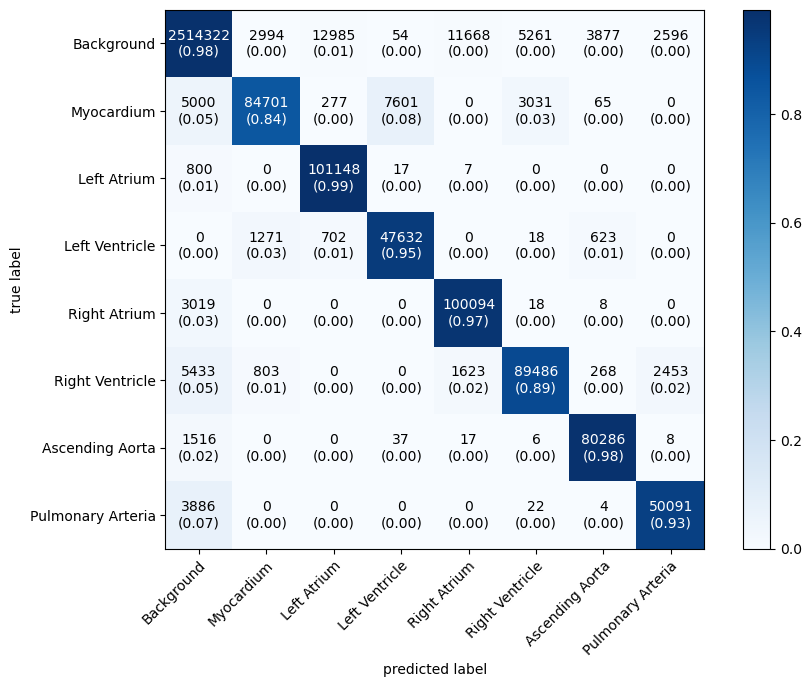

In [7]:
plot.plot_confusion_matrix(prediction_list = prediction_list,
                           label_list = label_list,
                           class_names = class_names)

## 6. Rescale the predictions

In [8]:
path_test_images = (in_dir.parent / 'data' / 'test_volumes').glob('*.nii.gz')
rescaled_predictions = data_setup.rescale_predictions(prediction_list = prediction_list,
                          file_path = path_test_images)

[INFO] Length of prediction list: 3
[INFO] Number of image files in directory: 3


## 7. Create a mesh

### 7.1 Create a mesh dataset with one dataset of the rescaled predictions

In [9]:
vertices_list, faces_list = plot.generate_mesh(rescaled_prediction = rescaled_predictions[1])

### 7.2 Plot the mesh dataset
* If you dont have class names, remove the `class_names` parameter

In [ ]:
plot.plot_mesh(vertices_list = vertices_list,
               faces_list = faces_list,
               class_names = class_names)

### 7.3 Save the mesh dataset as a .ply file

In [10]:
utils.save_ply(vertices_list[0],
         faces_list[0])

[INFO] Number Vertices 338757
[INFO] Number Faces 677534


## 8. Create a directory for the predictions and save the predictions as a nifti file

In [20]:
out_dir = Path.cwd().parent / 'data' / 'predictions'
utils.save_nifti(prediction_list = rescaled_predictions,
                  out_dir = out_dir)

[INFO] Saving prediction_0 Nifti file to c:\Users\graumnitz\Desktop\Heart_segmentation\data\predictions
[INFO] Saving prediction_1 Nifti file to c:\Users\graumnitz\Desktop\Heart_segmentation\data\predictions
[INFO] Saving prediction_2 Nifti file to c:\Users\graumnitz\Desktop\Heart_segmentation\data\predictions
